In [36]:
import os 

import pandas as pd
import pyarrow.parquet as pq

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

plt.style.use('fivethirtyeight')
plt_kwargs = {'figsize': (10, 4)}
#palette = sns.color_palette(['#088da5'])

In [37]:
roundsPath = "data/matches/silver/rounds"
killsPath = "data/matches/silver/kills"
mapDataPath = "data/maps/map_data.csv"

map_name = "de_inferno"
map_render = "data/maps/maps_display/"+map_name+".png"

In [38]:
map_data = pd.read_csv(mapDataPath)
map_data.rename(columns={'Unnamed: 0' : 'map'},inplace=True)

idx_ref = map_data.columns
cl_ref = map_data['map'].values

map_data.drop(columns='map', inplace=True)

map_data = map_data.T
map_data.columns = cl_ref

In [39]:
startX = map_data[map_name][-2]
endX = map_data[map_name][0]
resX = map_data[map_name][2]

startY = map_data[map_name][-1]
endY = map_data[map_name][1]
resY = map_data[map_name][3]

def pointx_to_resolutionx(xinput,startX=startX,endX=endX,resX=resX):
    sizeX=endX-startX
    if startX < 0:
        xinput += startX *(-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput

def pointy_to_resolutiony(yinput,startY=startY,endY=endY,resY=resY):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = ((yinput / abs(sizeY)) * resY);
    return resY-youtput

In [73]:
def map_plot(frame, x, y, color_map, img,s):

    img = plt.imread(img)
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(img)

    plot = ax.scatter(frame[x],frame[y],
              color=['r' if x == 'FURIA' else 'b' for x in frame[color_map]],alpha=.5,s=s)
    
    return plot

In [74]:
rounds = pq.ParquetDataset(roundsPath).read().to_pandas()

In [42]:
kills = pq.ParquetDataset(killsPath).read().to_pandas()

In [43]:
df = kills.merge(rounds, right_on=['id','round_number'],
           left_on=['id','round_number'])

In [44]:
df = df.copy()[['id', 'killer_side', 'killer_team', 'killed_side', 'killed_team',
       'killer_name', 'killed_name', 'assister_name', 'killer_x', 'killer_y',
       'round_number', 'victim_x', 'victim_y', 'seconds', 'element', 'type',
       'weapon_name', 'time_death_seconds', 'map_name',
       'end_reason', 'winner_side', 'winner_name',
       'team_t_name', 'team_ct_name', 'equipement_value_team_t',
       'equipement_value_team_ct', 'start_money_team_t', 'start_money_team_ct',
       'duration']]

## Keys dropped:
# non-valuable features: all counts, tick
# data leakage: kills_count

In [45]:
## Fixing column names for FURIA case 
# Consider this step to be done for the others teams as well (currently=MIBR and EG)

df['team_ct_name'] = df['team_ct_name'].apply(lambda x: x if "FURIA" not in x else "FURIA") \
    .apply(lambda y: y if "Evil" not in y else "EG") \
    .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip()

df['team_t_name'] = df['team_t_name'].apply(lambda x: x if "FURIA" not in x else "FURIA") \
    .apply(lambda y: y if "Evil" not in y else "EG") \
    .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip()

df['killer_team'] = df['team_ct_name'].apply(lambda x: x if "FURIA" not in x else "FURIA") \
    .apply(lambda y: y if "Evil" not in y else "EG") \
    .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip()

df['killed_team'] = df['team_t_name'].apply(lambda x: x if "FURIA" not in x else "FURIA") \
    .apply(lambda y: y if "Evil" not in y else "EG") \
    .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip()

# Creating binary target for rounds that FURIA has won

df['winner'] = pd.Series(np.where(df.winner_side == 'CT', df.team_ct_name, df.team_t_name)).apply(lambda x: x if "FURIA" not in x else "FURIA") \
    .apply(lambda y: y if "Evil" not in y else "EG") \
    .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip() \
    .apply(lambda k: 1 if k == 'FURIA' else 0)

# Defining binary target for sides

df['killer_side'] = df['killer_side'].apply(lambda x: 1 if x=="CT" else 0)

df['killed_side'] = df['killed_side'].apply(lambda x: 1 if x=="CT" else 0)

df['winner_side'] = df['killed_side'].apply(lambda x: 1 if x=="CT" else 0)

# Creating binary target for kills that has assists

df['has_assist'] = df['assister_name'].apply(lambda x: 0 if x == None else 1)

# Scalling coordinates 

coordinatedColumns =  ['killer_x', 'killer_y','victim_x','victim_y']
for cl in coordinatedColumns:
    if 'x' in cl:
        df[cl] = df[cl].apply(lambda x: pointx_to_resolutionx(x))
    else:
        df[cl] = df[cl].apply(lambda y: pointy_to_resolutiony(y))

In [46]:
for column in df.columns:
    if(df[column].dtype == 'O'):
        df[column] = df[column].apply(lambda y: y.strip() if type(y) == str else y) \
        .apply(lambda x: None if x == "" else x)

In [47]:
# Dropping columns that won't scale for the modelling

df.drop(columns=['id',"assister_name"], inplace=True)
df.dropna(inplace=True)

# Creating a new slice by selecting a single map

df = df.copy().loc[df["map_name"] == map_name]
df.reset_index(drop=True, inplace=True)

In [48]:
# Splitting features by X, y

X = df.copy().drop(columns=['winner','map_name','winner_name','winner_side','end_reason'])
y = df.copy()['winner']

### Data Explore

<AxesSubplot:>

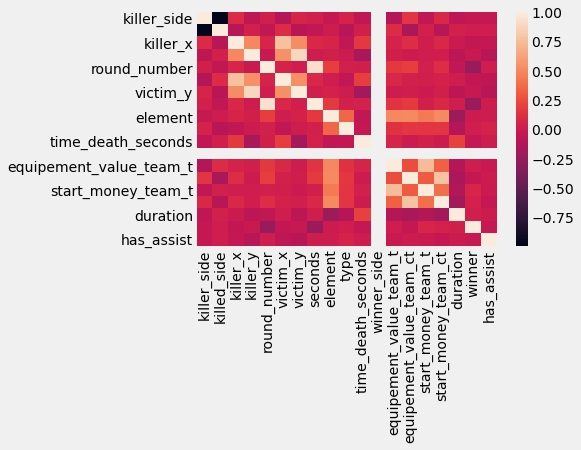

In [49]:
sns.heatmap(df.corr())

In [76]:
kills = df.copy()

In [82]:
kills = kills.loc[(kills['winner'] == 1) & (kills['killed_team'] != 'FURIA')]

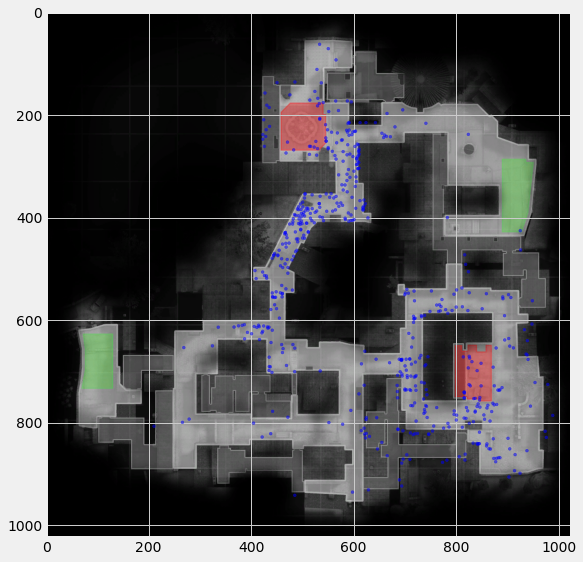

In [83]:
map_plot(kills, 'victim_x', 'victim_y','killed_team',map_render,s=8)

### Feature Treatment

In [51]:
FEATURES = ['killer_side', 'killer_team', 'killed_side', 'killed_team',
       'killer_name', 'killed_name', 'killer_x', 'killer_y', 'round_number',
       'victim_x', 'victim_y', 'weapon_name', 'team_t_name', 'team_ct_name', 'equipement_value_team_t',
       'equipement_value_team_ct', 'start_money_team_t', 'start_money_team_ct']

TARGET = 'winner'

In [52]:
# Splitting features by X, y

X = df.copy()[FEATURES]
y = df.copy()[TARGET]

In [53]:
to_transform = []

for column in X.columns:
    if(X[column].dtype == 'O'):
        to_transform.append(column)

In [54]:
inverse_transform = {}

In [55]:
for column in to_transform:
    labelEncoder = pd.Series(X[column].unique()).reset_index().set_index(0).to_dict()['index']
    
    ## Creating and storing inverseEncode
    inverseEncoder = pd.Series(df[column].unique()).reset_index() \
    .rename(columns={0:column}).set_index('index').to_dict()[column]
    
    inverse_transform[column] = inverseEncoder
    
    # Mapping label encoding
    X[column] = X[column].map(labelEncoder).astype(int)

### Modelling

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)

In [58]:
xgb = XGBClassifier(use_label_encoder=False)
gbc = GradientBoostingClassifier()

In [59]:
xgb.fit(X_train, y_train)

[01:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [60]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [61]:
feature_importance = pd.DataFrame(
    gbc.feature_importances_,index=X.columns,columns=['importance']) \
    .sort_values(by='importance', ascending=False)

### Evaluating

In [62]:
xgb_train_score, xgb_test_score = xgb.score(X_train, y_train), xgb.score(X_test, y_test)

In [63]:
gbc_train_score, gbc_test_score = gbc.score(X_train, y_train), gbc.score(X_test, y_test)

In [64]:
print("*XGBoost*\n-> train:{:.2f}\n-> test:{:.2f}\n\n*GBC\n-> train:{:.2f}\n-> test:{:.2f}".
      format(xgb_train_score, xgb_test_score,gbc_train_score, gbc_test_score ))

*XGBoost*
-> train:1.00
-> test:0.99

*GBC
-> train:0.93
-> test:0.90


In [65]:
evaluate = X_test.copy()
evaluate['pred'] = y_test.copy()
evaluate['win_chance'] = [x[1] for x in xgb.predict_proba(X_test)]

In [66]:
for col in to_transform:
    evaluate[col] = evaluate[col].map(inverse_transform[col])

In [68]:
feature_importances = xgb.get_booster().get_score(importance_type="gain")

In [69]:
importances = pd.Series(feature_importances, name='importance') \
                    .to_frame().sort_values(by='importance', ascending=False)

<AxesSubplot:xlabel='importance'>

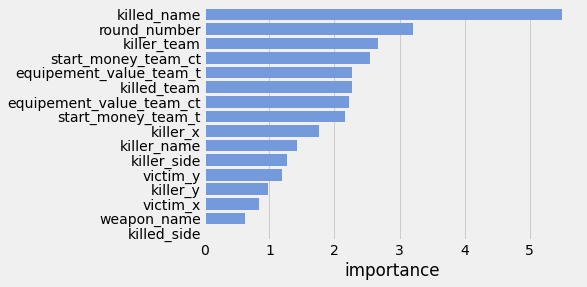

In [70]:
sns.barplot(x=importances.importance, y=importances.index, data=importances, color='cornflowerblue')